In [27]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
%matplotlib inline

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [19]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [14]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [11]:
series = pd.read_csv(r'C:\Users\79169\Desktop\домашка\ts\Series\daily-total-female-births-in-cal.csv')

In [4]:
series = pd.read_csv(r'C:\Users\79169\Desktop\домашка\ts\Series\daily-total-female-births-in-cal.csv')['Count']

In [117]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

Попробуем сгладить стационарный ряд с помощью MA и ЕМА

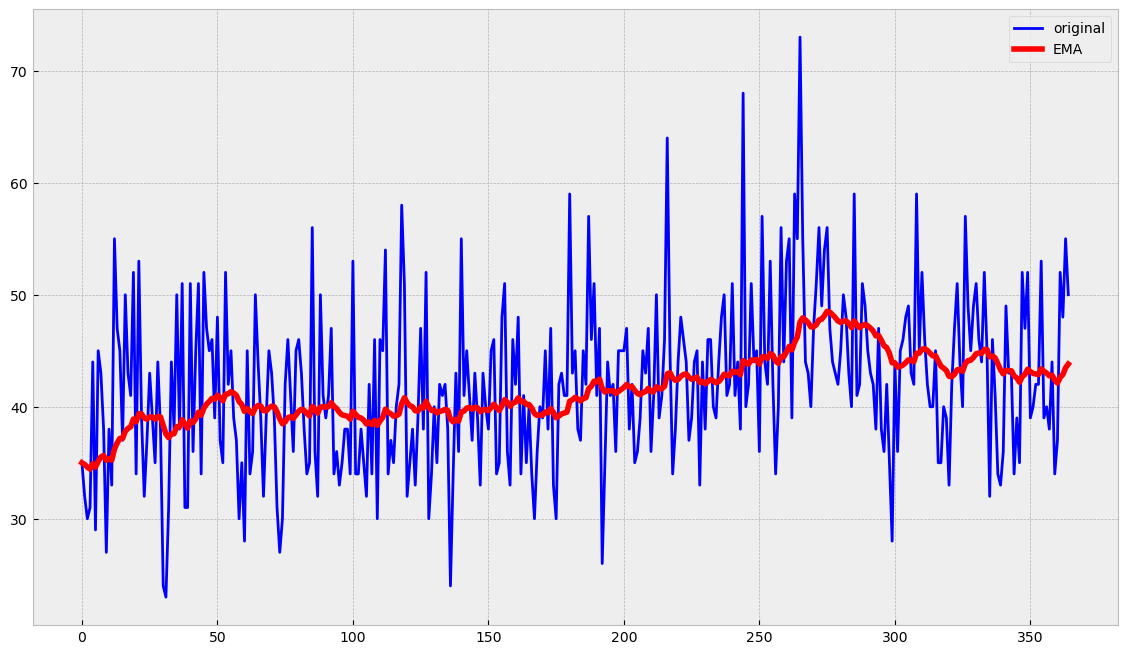

In [122]:
ser_1 = exponential_moving_average(series["Count"], 0.05)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series["Count"], color='blue',label='original')
    plt.plot(ser_1, color='red', linewidth='4', label='EMA')
    plt.legend()

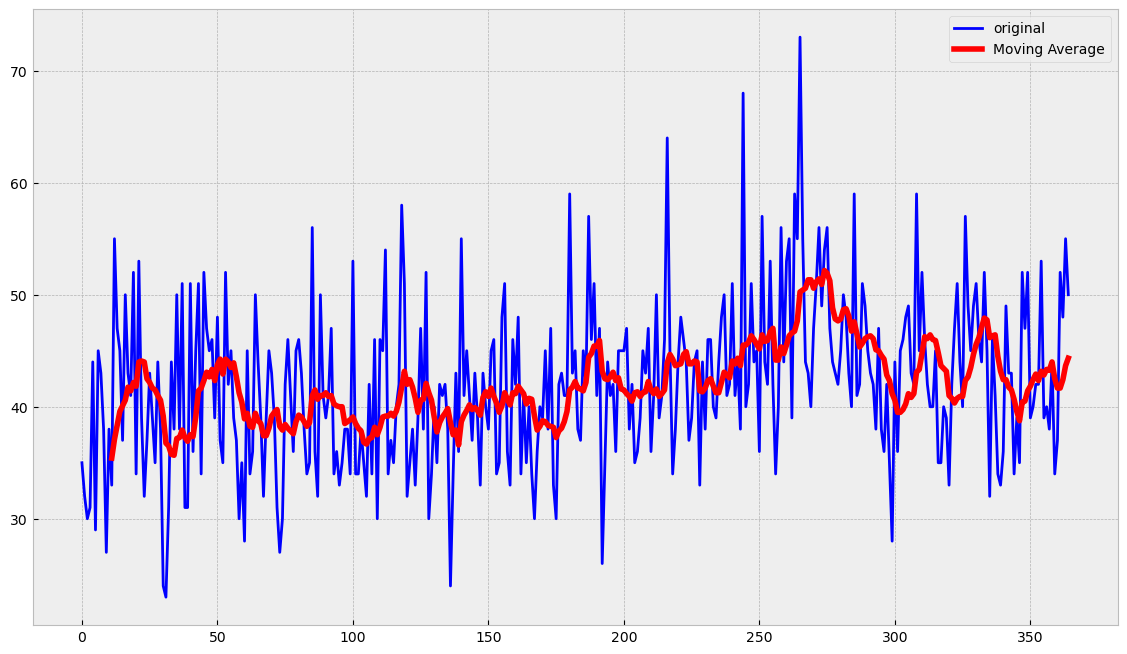

In [127]:
ser = moving_average(series["Count"], 12)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series["Count"], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Для анализа взяли именно ема и ма, так как в нем нет сезонности/тренда и сбалансирован по дисперсии; причем ема будет лучше - так как более устойчива к выбросам

In [6]:
trading = pd.read_csv(r'C:\Users\79169\Desktop\домашка\ts\Series\weekly-closings-of-the-dowjones-.csv')

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


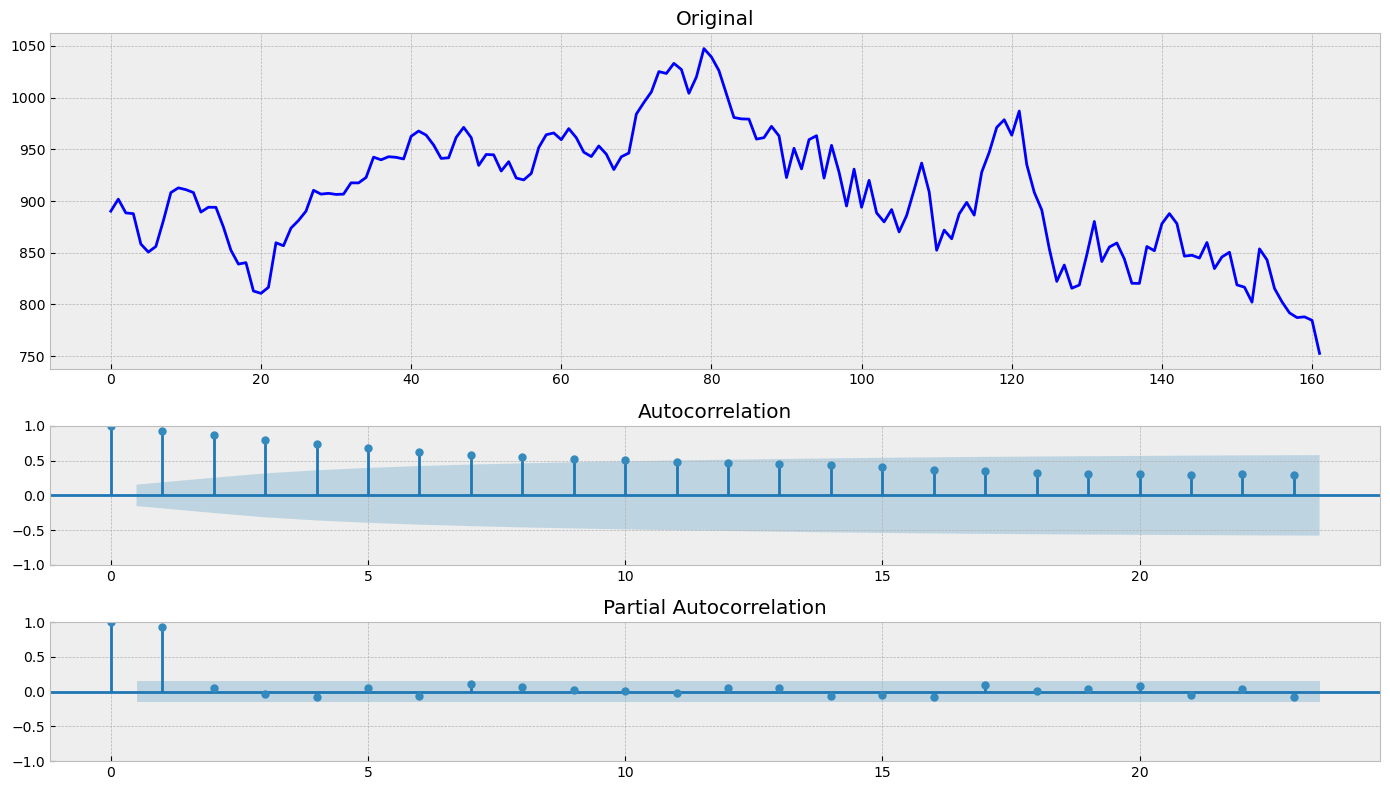

In [5]:
trading = pd.read_csv(r'C:\Users\79169\Desktop\домашка\ts\Series\weekly-closings-of-the-dowjones-.csv')['Close']
tsplot(trading)

In [24]:
ema = double_ema(trading['Close'], 0.5, 0.3)

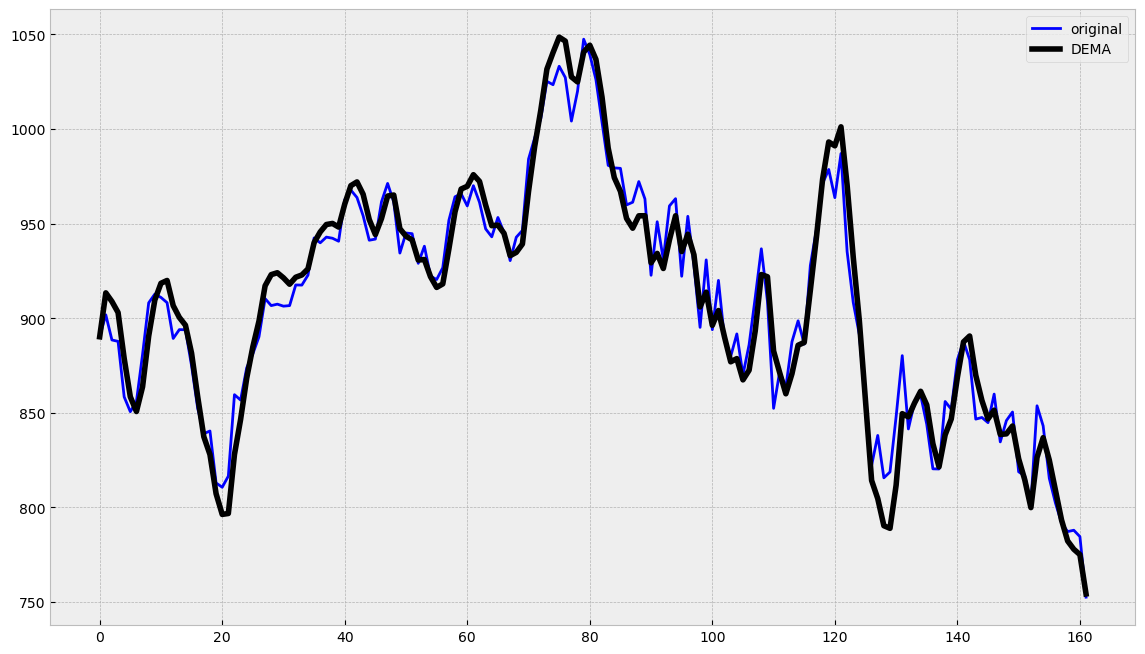

In [123]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(trading['Close'], color='blue',label='original')
    plt.plot(ema, color='black', linewidth='4', label='DEMA')
    plt.legend()

In [28]:
trading_s = pd.read_csv(r'C:\Users\79169\Desktop\домашка\ts\Series\weekly-closings-of-the-dowjones-.csv')['Close']

In [29]:
trading_s.shape

(162,)

In [45]:
train, val = trading_s[:81], trading_s[81:]

In [46]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

C:\Users\79169\AppData\Local\Temp\ipykernel_8908\2601243732.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)


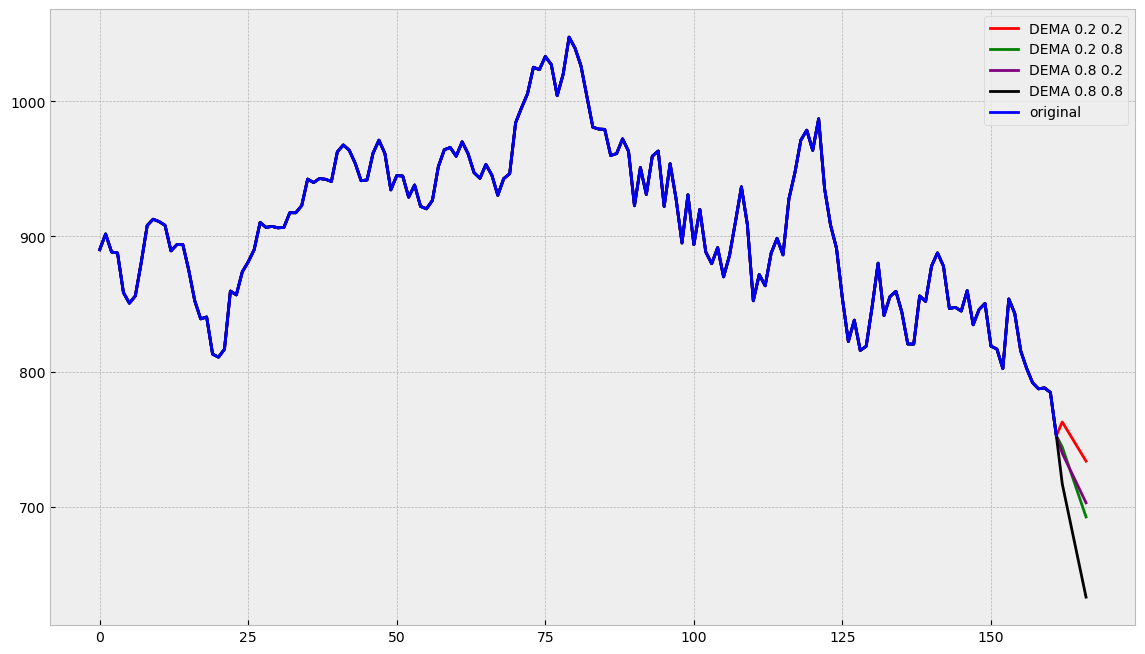

In [47]:
alphas = [0.2,0.2,0.8,0.8]
bettas = [0.2,0.8,0.2,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(trading_s, alphas[i], bettas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(trading_s, color='blue',label='original')
    plt.legend()

Для анализа данного временного ряда была применена DEMA - так как здесь присутствует тренд и осутствует сезонность; и выполнили предсказание 

Теперь посчитаем ошибки и найдем оптимальные параметры DEMA

In [57]:
def mse_cross_val(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = double_ema(train_split_ts, alpha, beta)
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    
    mean_error = np.mean(errors)
    print(f'{mean_error}------------')
    return mean_error

In [143]:
opt = minimize(mse_cross_val, x0=[0,0], method="COBYLA", bounds = [(0.2, 1), (0.2, 1)])

122383.67918333087------------
3067.5210083333386------------
4060.741476666666------------
4009.3673060831984------------
3146.347504700634------------
4073.6821993758044------------
4014.903061845574------------
3989.734782384414------------
4010.0236771545838------------
4007.422825455183------------
4009.448798438841------------
4009.1309610832254------------
4009.375643628298------------
4009.343190735813------------


In [144]:
alpha_opt, beta_opt = opt.x
print(opt)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 4009.3673060831984
       x: [ 1.000e+00  2.000e-01]
    nfev: 14
   maxcv: -0.0


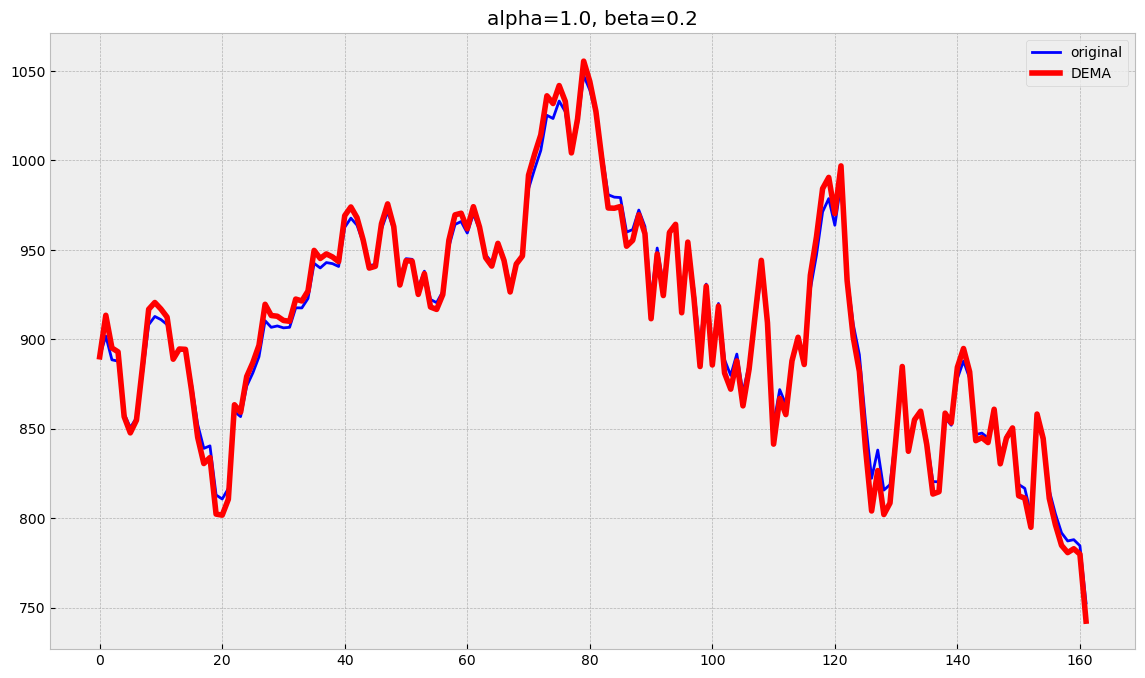

In [145]:
plot_dema(alpha_opt, beta_opt)

Как мы видим, при данных значениях параметров, DEMA практически идеально повторяет данный временной ряд